In [189]:
import sys
sys.path.append('../')

import pandas as pd
import geopandas as gpd
from access import access, weights

# How to Use `access` to Compute Access Scores to Resources Given XY Coordinates
A common use case for using `access` is to calculate access scores from an origin tract to the aggregated resources available within a destination tract's population weighted centroid. In certain cases, we might be interested in measuring access to the exact locations of the resource, such as a hospital or grocery store. While the pre-computed cost matrix would not be useful for this use case, the `access` package can still be used to calculate the euclidean distances from origin tracts' population weighted centroids to the resource located at specific coordinates. 

In this notebook, we'll show an example of calculating access scores to individual hospitals in Cook County (and nearby) from Cook County census tracts given the exact coordinates of those hospitals. 

We'll show you how to:
- Join Cook County population data with a geospatial dataset for Cook County Census tracts
- Load in Cook County Hospital data and create geometric points from the XY coordinates
- Calculate euclidean distances between each of the Cook County Census tracts and the hospitals
- Calculate access measures

## Join Population Data with Geospatial Representation of Census Tracts
To complete this first step, we'll need two files:
- Cook County population data at the census tract level
- geospatial representation of Cook County Census Tracts

First, we'll load a dataset containing population counts for Cook County at the Census Tract level.

In [25]:
cook_county_population = pd.read_csv('./cook_county_population_tracts.csv')
cook_county_population.head()

,geoid,pop
0,17031010100,4854
1,17031010201,6450
2,17031010202,2818
3,17031010300,6236
4,17031010400,5042


Next, we'll load in a `.geojson` file of Cook County Census Tracts. ***To see how to produce a `.geojson` file starting from a larger shapefile, see our notebook [How to Subset a Geospatial Shapefile and Convert to .geojson](placeholder).***

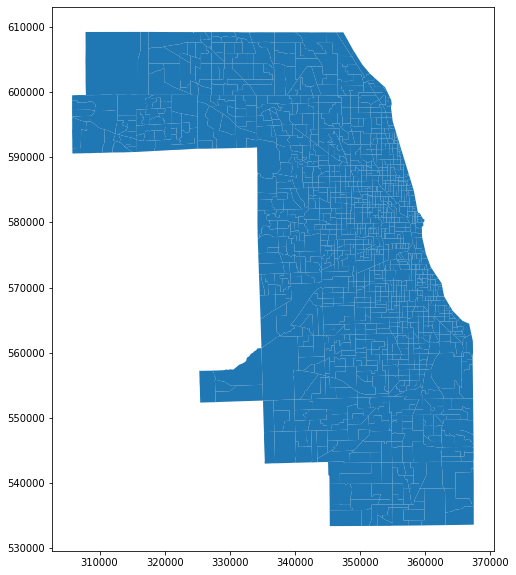

In [3]:
cook_county_tracts = gpd.read_file('./cook_county_tracts.geojson')
cook_county_tracts.plot(figsize=(10,10))

Now we will join the geospatial representations of Cook County Tracts to the population data and plot the population numbers so that we can see the differences at the tract level.

In [4]:
cook_county_geopop = cook_county_tracts.merge(cook_county_population, on='geoid')
cook_county_geopop.head()

,GEO_ID,STATE,COUNTY,TRACT,NAME,LSAD,CENSUSAREA,geoid,geometry,pop
0,1400000US17031440300,17,031,440300,4403,Tract,0.499,17031440300,"POLYGON ((359779.998 563694.900, 359785.854 56...",4757
1,1400000US17031440600,17,031,440600,4406,Tract,0.259,17031440600,"POLYGON ((359797.310 563086.247, 359800.394 56...",2080
2,1400000US17031440700,17,031,440700,4407,Tract,0.126,17031440700,"POLYGON ((360201.128 563098.184, 360402.583 56...",1545
3,1400000US17031460200,17,031,460200,4602,Tract,0.232,17031460200,"POLYGON ((364927.536 564034.757, 365032.657 56...",2385
4,1400000US17031460600,17,031,460600,4606,Tract,0.101,17031460600,"POLYGON ((364641.501 563219.094, 364699.974 56...",1183


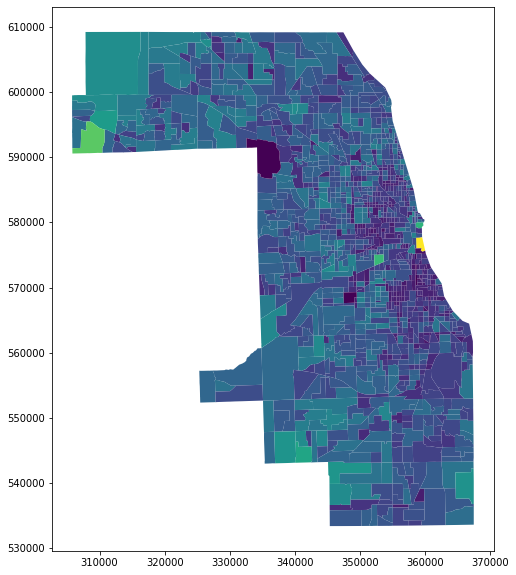

In [5]:
cook_county_geopop.plot(column='pop', figsize=(10,10))

## Load Cook County Hospital Data and Create Geometric Points from the XY Coordinates
Next up, well load the hospital data which has an XY coordinate pair for each hospital. Using the XY coordinates, we will create geospatial points which can then be used to calculate the distances between the cencus tracts and hospitals.

As shown below, the dataset contains X and Y coordinates for the locations of the hospitals.

In [6]:
cook_county_hospitals = pd.read_csv('./cook_county_hospitals.csv')
cook_county_hospitals.head()

,ADDRESS,CFNAME,CFSUBTYPE,CFTYPE,Community,GNISCODE,Jurisdicti,OBJECTID,SOURCE,COORD_X,COORD_Y
0,9340 S Kostner Ave,Advocate Christ Medical Center,Hospital,Hospital,Oak Lawn,426825.0,NaN,1,CGI,-87.732438,41.722202
1,15300 West Ave,Palos Primary Care Center,Hospital,Hospital,Orland Park,2036658.0,NaN,2,CL,-87.865552,41.610533
2,15901 Cicero Ave,Oak Forest Hospital,Hospital,Hospital,Bremen Twp,414760.0,NaN,3,CEGL,-87.731486,41.599667
3,375 W North Ave,Gottlieb Memorial Hospital,Hospital,Hospital,Melrose Park,409212.0,NaN,4,BCEG,-87.843465,41.910779
4,2100 Pfingsten Rd,Glenbrook Hospital,Hospital,Hospital,Glenview,2033578.0,NaN,5,CEGI,-87.851615,42.092630


Using the dataset above, we can create a [`geopandas.GeoDataFrame`](http://geopandas.org/reference/geopandas.GeoDataFrame.html) and with the `gpd.points_from_xy` create geometric points for each hospital.

In [7]:
cook_county_hospitals_geom = gpd.GeoDataFrame(cook_county_hospitals, geometry = gpd.points_from_xy(cook_county_hospitals.COORD_X, cook_county_hospitals.COORD_Y))
cook_county_hospitals_geom.head()

,ADDRESS,CFNAME,CFSUBTYPE,CFTYPE,Community,GNISCODE,Jurisdicti,OBJECTID,SOURCE,COORD_X,COORD_Y,geometry,value
0,9340 S Kostner Ave,Advocate Christ Medical Center,Hospital,Hospital,Oak Lawn,426825.0,NaN,1,CGI,-87.732438,41.722202,POINT (-87.73244 41.72220),1
1,15300 West Ave,Palos Primary Care Center,Hospital,Hospital,Orland Park,2036658.0,NaN,2,CL,-87.865552,41.610533,POINT (-87.86555 41.61053),1
2,15901 Cicero Ave,Oak Forest Hospital,Hospital,Hospital,Bremen Twp,414760.0,NaN,3,CEGL,-87.731486,41.599667,POINT (-87.73149 41.59967),1
3,375 W North Ave,Gottlieb Memorial Hospital,Hospital,Hospital,Melrose Park,409212.0,NaN,4,BCEG,-87.843465,41.910779,POINT (-87.84347 41.91078),1
4,2100 Pfingsten Rd,Glenbrook Hospital,Hospital,Hospital,Glenview,2033578.0,NaN,5,CEGI,-87.851615,42.092630,POINT (-87.85161 42.09263),1


Next, we'll assign a coordinate reference system (CRS) code to the dataset and then we can plot the points.

In [8]:
cook_county_hospitals_geom.crs = {'init':'epsg:4326'}
cook_county_hospitals_geom = cook_county_hospitals_geom.to_crs(epsg=3528)

We can now plot these points on top of the Census Tracts.

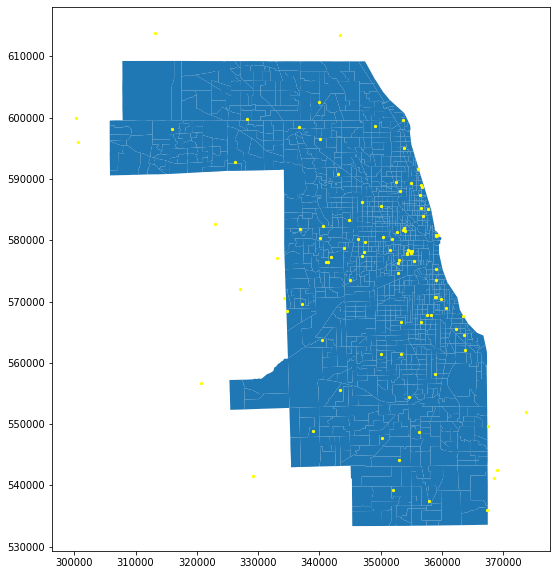

In [9]:
base = cook_county_tracts.plot(figsize=(10,10))
cook_county_hospitals_geom.plot(ax=base, color='yellow', markersize = 5, figsize=(10,10))

## Calculating Euclidean Distances Between Hospitals and Census Tracts
Now that we have geometric representations of both Cook County Census Tracts and the hospitals, we can use the `access` package's [`access.euclidean_distance()`](https://access.readthedocs.io/en/latest/generated/access.access.euclidean_distance.html#access.access.euclidean_distance) method to calculate euclidean distances (in meters with the current projection) between each Census Tract and hospital within a max threshold distance. In this example, we will calculate distances from origin Census Tracts and hospitals up to 100km away.

First, we'll instantiate an instance of the `access` class by providing it our demand and supply datasets, the Cook County poulation data and hospital data, respectively.

In [191]:
cook_hospital_access = access(demand_df    = cook_county_geopop,
                              demand_index = 'geoid',
                              demand_value = 'pop',
                              supply_df    = cook_county_hospitals_geom,
                              supply_index = 'OBJECTID')

Now, we can calculate the euclidean distances between the centroids of our demand and supply geometries, applying the 100,000 meter threshold.

In [192]:
cook_hospital_access.euclidean_distance(name='euclidean', threshold=100000, centroid_d=True, centroid_o=True)
cook_hospital_access.cost_df.head()

,euclidean,origin,dest
0,9693.187072,17031440300,1
1,25269.468254,17031440300,2
2,18519.544850,17031440300,3
3,26273.695917,17031440300,4
4,43271.311959,17031440300,5


## Calculate Access Measures
Having calculated our cost matrix with euclidean distances as our cost measure, we can now begin to calculate access scores. Below we show how to calculate and visualize gravity model scores and a custom, user-defined weighted step function.

### Gravity Model
To calculate a gravity score, we must first define a gravity weight function. Once we've defined our weight function, we can pass that as an argument to the [`access.weighted_catchment()`](https://access.readthedocs.io/en/latest/generated/access.fca.weighted_catchment.html#access.fca.weighted_catchment) method. After calling the method, you'll see access score output.

In [193]:
gravity = weights.gravity(scale = 60, alpha = -1)

In [194]:
cook_hospital_access.weighted_catchment(name = "gravity", weight_fn = gravity)

,gravity_value
geoid,
17031010100,0.391604
17031010201,0.413334
17031010202,0.400508
17031010300,0.388658
17031010400,0.432838
...,...
17031843700,0.561835
17031843800,0.573198
17031843900,0.499082


Now, we'll plot our gravity score.

In [195]:
def plot_access_measure(access_metric):
    cook_map = cook_county_geopop[["geoid","geometry"]].set_index('geoid').join(cook_hospital_access.access_df, how = "inner")
    base = cook_map.plot(access_metric, legend = True, 
                         figsize = (15, 15), 
                         cmap = "viridis", 
                         markersize = .5, 
                         alpha = 1,
                         vmin = cook_map[v].quantile(0.05), vmax = cook_map[v].quantile(0.95))
    cook_county_hospitals_geom.plot(ax=base, markersize=7, color='orange')

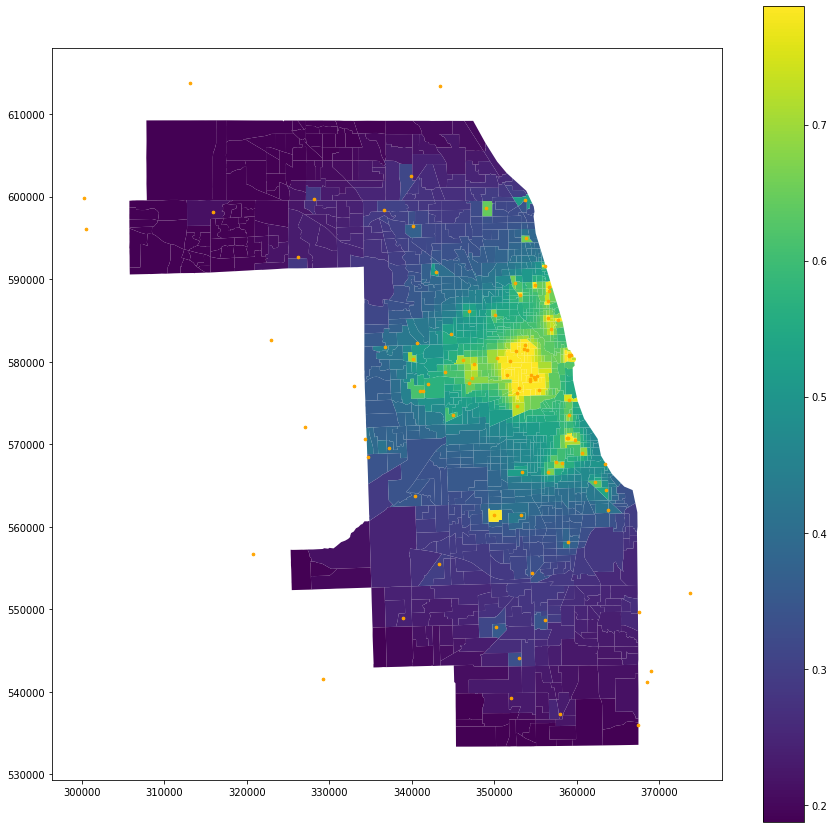

In [196]:
plot_access_measure('gravity_value')

### Custom Weight Step Function
You can also define your own weight function using the `weights.step_fn()` method. In the example below, we show a step function implemented using the `{distance_threshold_1: weight_1, distance_threshold_2: weight_2, ...:..., distance_threshold_n...: weight_n...}` structure where `distance_threshold_n-1 < distance_threshold_n`.

In [197]:
custom_step_fn = weights.step_fn({1000:1, 2000:.5, 3000:.3, 4000:.2, 5000:.1})
cook_hospital_access.weighted_catchment(name='custom', weight_fn=custom_step_fn)

,custom_value
geoid,
17031010100,0.7
17031010201,1.4
17031010202,0.9
17031010300,0.9
17031010400,1.3
...,...
17031843700,2.3
17031843800,2.5
17031843900,2.2


Now we plot our custom weighted access measure.

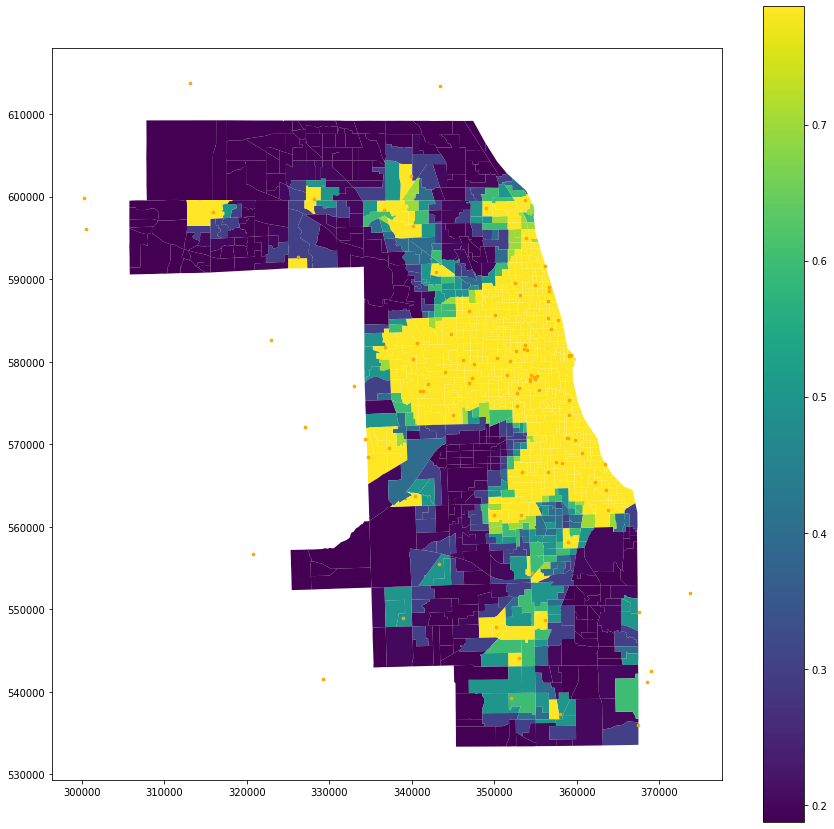

In [198]:
plot_access_measure('custom_value')

## Saving Access Measures to a CSV
Finally, view each of the access measures you've calculated by accessing the `access_df` attribute. You can save your access measures to a csv as shown below.

In [199]:
cook_hospital_access.access_df

,pop,gravity_value,custom_value
geoid,,,
17031010100,4854,0.391604,0.7
17031010201,6450,0.413334,1.4
17031010202,2818,0.400508,0.9
17031010300,6236,0.388658,0.9
17031010400,5042,0.432838,1.3
...,...,...,...
17031843700,2117,0.561835,2.3
17031843800,2110,0.573198,2.5
17031843900,3533,0.499082,2.2


In [200]:
cook_hospital_access.access_df.to_csv('./cook_county_hospital_access_measures.csv')